In [147]:
import subprocess as sp
import os
import silence_tensorflow.auto # pylint: disable=unused-import
import tensorflow as tf

def mask_unused_gpus(leave_unmasked=1):

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"

  try:
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    available_gpus = [i for i, x in enumerate(memory_free_values) if x > ACCEPTABLE_AVAILABLE_MEMORY]

    if len(available_gpus) < leave_unmasked: raise ValueError('Found only %d usable GPUs in the system' % len(available_gpus))
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    tf.config.experimental.set_visible_devices(gpus[available_gpus[0]], 'GPU')
  
  except Exception as e:
    print('"nvidia-smi" is probably not installed. GPUs are not masked', e)

mask_unused_gpus()

"nvidia-smi" is probably not installed. GPUs are not masked Visible devices cannot be modified after being initialized


In [148]:
import absl.logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
absl.logging.set_verbosity(absl.logging.ERROR)

In [149]:
os.chdir('/home/ricky/RNNAE')

data_GP = np.array(np.load('data_GP.npy', allow_pickle=True))
data_meta_GP = np.array(np.load('data_meta_GP.npy', allow_pickle=True))

In [150]:
def create_input(split_portion=0.8, num_of_type=1):

    claimedtype = []

    input = [ [] for i in range(num_of_type+1)]
    input_train = [ [] for i in range(num_of_type+1)]
    input_test = [ [] for i in range(num_of_type+1)]
    type_train = [ [] for i in range(num_of_type+1)]
    type_test = [ [] for i in range(num_of_type+1)]

    for i in range(len(data_meta_GP)):

        if 'Ia' in data_meta_GP[i][-2]:
            claimedtype.append(0)
        if 'IIP' in data_meta_GP[i][-2]:
            claimedtype.append(1)

    for i in range(len(claimedtype)):

        input[0].append(list(data_GP[i]))

        if claimedtype[i] == 0:
            input[1].append(list(data_GP[i]))
        if claimedtype[i] == 1:
            input[2].append(list(data_GP[i]))

    for i in range(len(input)):
        
        input[i] = np.array(input[i])

        input_train[i] = input[i][:int(split_portion*len(input[i]))]
        input_test[i]  = input[i][int(split_portion*len(input[i])):]

        input[i] = K.cast_to_floatx(input[i].transpose((0, 2, 1)))
        input_train[i] = K.cast_to_floatx(input_train[i].transpose((0, 2, 1)))
        input_test[i] = K.cast_to_floatx(input_test[i].transpose((0, 2, 1)))

        '''input[i] = np.reshape(input[i],(input[i].shape[0], input[i].shape[1], input[i].shape[2], 1) )
        input_train[i] = np.reshape(input_train[i], (input_train[i].shape[0], input_train[i].shape[1], input_train[i].shape[2], 1))
        input_test[i] = np.reshape(input_test[i], (input_test[i].shape[0], input_test[i].shape[1], input_test[i].shape[2], 1))'''

        input[i] = np.repeat(input[i][:,:,1:-3], 16, axis=1)
        input_train[i] = np.repeat(input_train[i][:,:,1:-3], 16, axis=1)
        input_test[i] = np.repeat(input_test[i][:,:,1:-3], 16, axis=1)

        input[i] = np.reshape(input[i],(input[i].shape[0], int(input[i].shape[1]/16), int(input[i].shape[2]*16), 1))
        input_train[i] = np.reshape(input_train[i],(input_train[i].shape[0], int(input_train[i].shape[1]/16), int(input_train[i].shape[2]*16), 1))
        input_test[i] = np.reshape(input_test[i],(input_test[i].shape[0], int(input_test[i].shape[1]/16), int(input_test[i].shape[2]*16), 1))

        type_train[i] = claimedtype[:int(split_portion*len(input[i]))]
        type_test[i]  = claimedtype[int(split_portion*len(input[i])):]

    for i in range(len(input)-1):
        print(f'For type {claimedtype[i]}, total size of data is {input[i].shape}, training size is {input_train[i].shape}, testing size is {input_test[i].shape}')

    return input, input_train, input_test, type_train, type_test

In [151]:
input, input_train, input_test, type_train, type_test = create_input()

For type 0, total size of data is (1144, 200, 48, 1), training size is (915, 200, 48, 1), testing size is (229, 200, 48, 1)


In [152]:
print(input_train[0][0][100])

[[-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]]


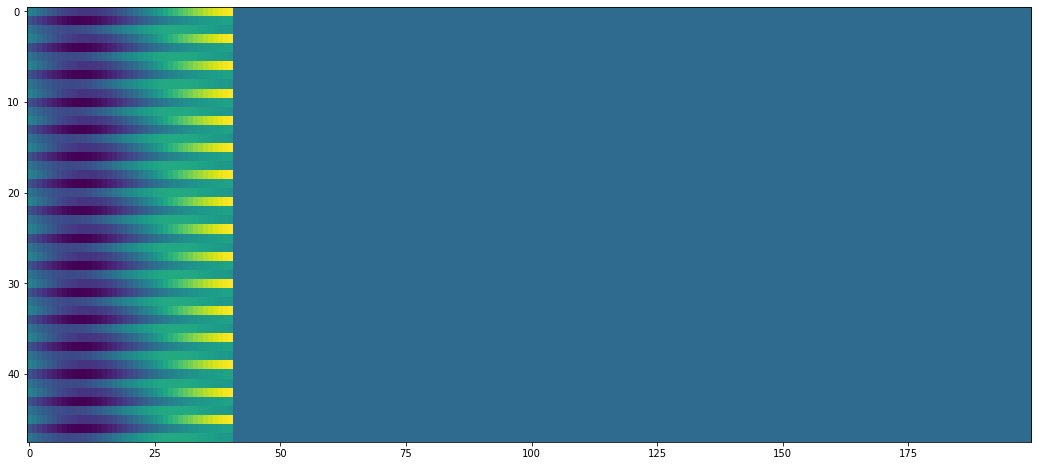

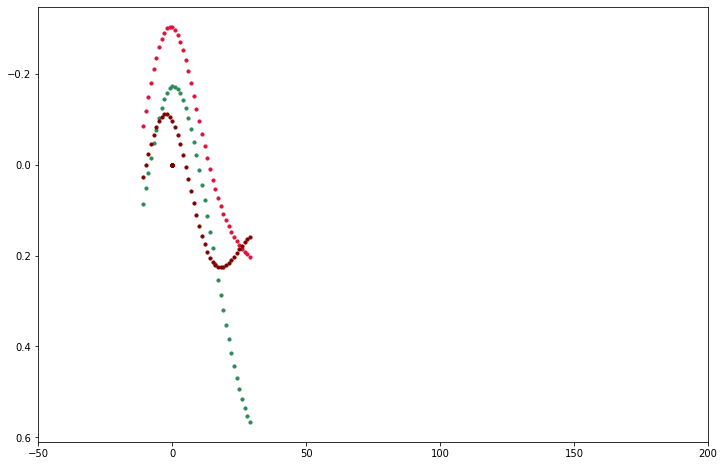

In [153]:
i = 2
fig = plt.figure(figsize=(18, 8))
plt.imshow(input_train[0][i].reshape(200,48).T, interpolation='nearest', aspect='auto')

fig = plt.figure(figsize=(12,8))
color1 = ['seagreen', 'crimson', 'maroon']
plt.gca().invert_yaxis()
plt.xlim(-50, 200)
for j in range(3):
    plt.scatter(data_GP[i,0,:], data_GP[i,j+1,:], s=10, marker='o', color=color1[j])

In [154]:
input = keras.Input(shape=(input[0].shape[1], input[0].shape[2], 1))

# Encoder
#x = BatchNormalization()(input)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

In [155]:
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 200, 48, 1)]      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 200, 48, 64)       640       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 100, 24, 64)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 100, 24, 64)       36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 50, 12, 64)        0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 100, 24, 64)       36928     
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 200, 48, 64)       369

In [156]:
autoencoder.fit(
    x=input_train[0],
    y=input_train[0],
    validation_split = 0.1,
    epochs=50,
)

Epoch 1/50
26/26 [==============================] - 29s 1s/step - loss: 0.0165 - val_loss: 0.0031
Epoch 2/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/50
26/26 [==============================] - 0s 18ms/step - loss: 8.7532e-04 - val_loss: 7.3729e-04
Epoch 5/50
26/26 [==============================] - 0s 18ms/step - loss: 5.9016e-04 - val_loss: 5.4280e-04
Epoch 6/50
26/26 [==============================] - 0s 18ms/step - loss: 4.5065e-04 - val_loss: 7.8896e-04
Epoch 7/50
26/26 [==============================] - 0s 17ms/step - loss: 5.2887e-04 - val_loss: 4.5193e-04
Epoch 8/50
26/26 [==============================] - 0s 17ms/step - loss: 3.7296e-04 - val_loss: 4.2101e-04
Epoch 9/50
26/26 [==============================] - 0s 17ms/step - loss: 3.6388e-04 - val_loss: 3.9362e-04
Epoch 10/50
26/26 [==============================] - 0s 17ms/s

In [157]:
predictions = autoencoder.predict(input_test[0])

In [158]:
print(predictions.shape)

(229, 200, 48, 1)


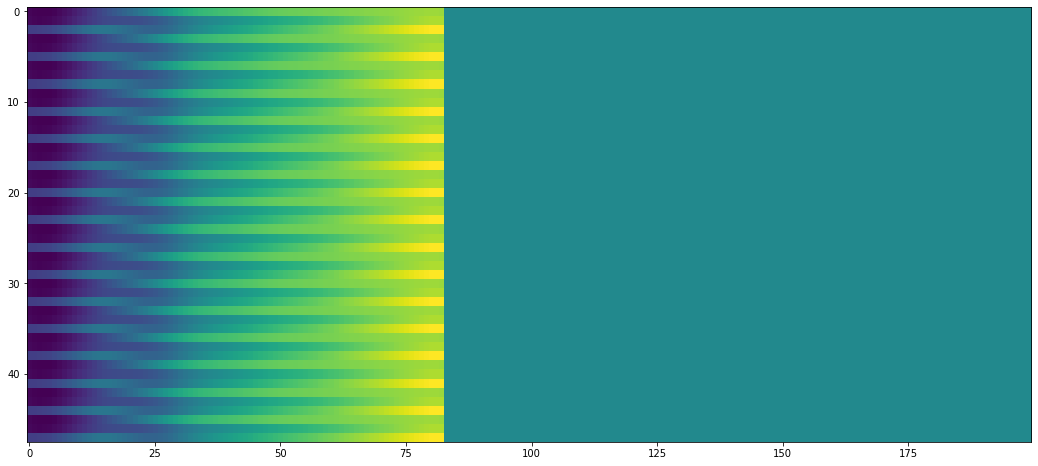

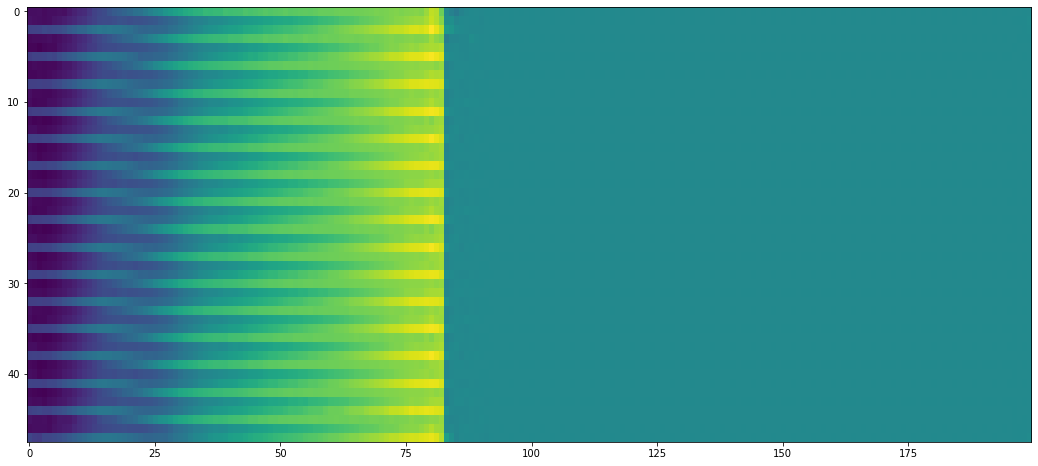

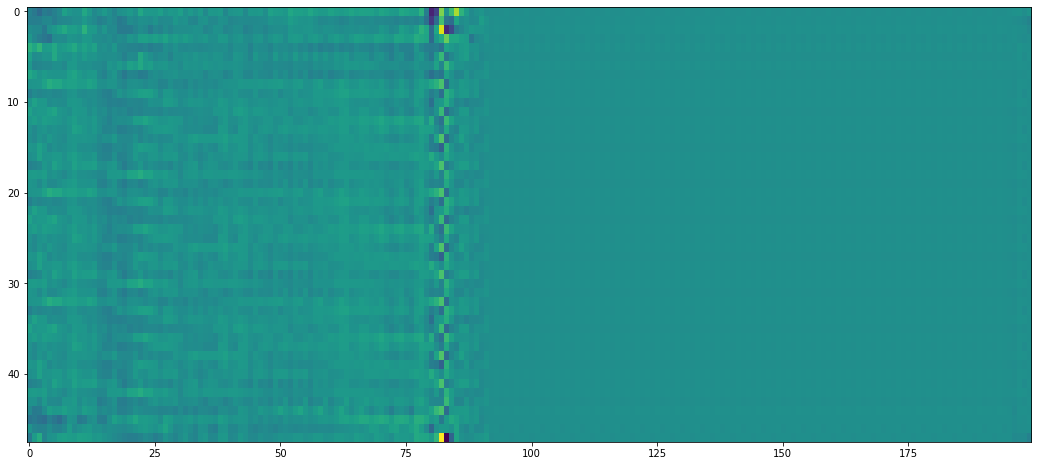

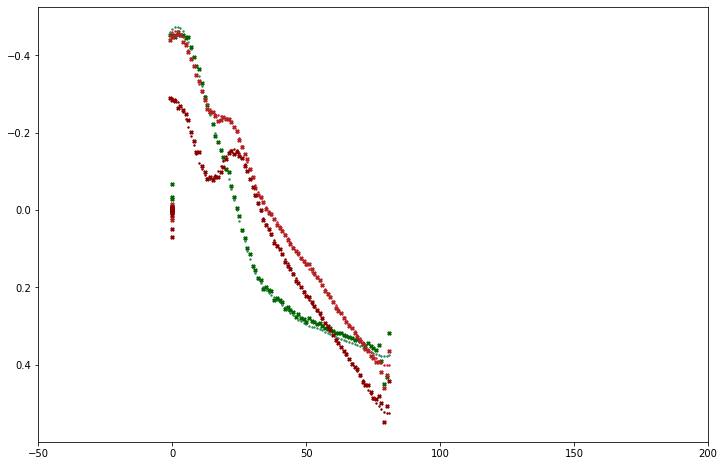

In [172]:
i = 11

fig = plt.figure(figsize=(18, 8))
plt.imshow(input_test[0][i].reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(18, 8))
plt.imshow(predictions[i].reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(18, 8))
plt.imshow(input_test[0][i].reshape(200,48).T - predictions[i].reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.gca().invert_yaxis()
plt.xlim(-50, 200)
split = int(0.8*(data_GP.shape[0]))
color1 = ['seagreen', 'crimson', 'maroon']
color2 = ['darkgreen', 'firebrick', 'darkred']
for j in range(3):
    plt.scatter(data_GP[i+split,0,:], input_test[0][i][:,j,:], s=2, marker='o', color=color1[j])
    plt.scatter(data_GP[i+split,0,:], predictions[i][:,j,:], s=12, marker='X', color=color2[j])

In [160]:
print(predictions[0].reshape(48,200)[0])

[0.18807986 0.21774134 0.20573719 0.19777435 0.20615944 0.21794876
 0.19080804 0.2067319  0.20629352 0.19872177 0.21182953 0.20762779
 0.19289419 0.21483953 0.20787393 0.1928571  0.20891017 0.21030264
 0.19376308 0.21036065 0.20629357 0.19872177 0.21182954 0.20762783
 0.19289422 0.21483953 0.20787393 0.19285709 0.20891021 0.21030274
 0.19376309 0.21036063 0.20629357 0.19872175 0.21182957 0.20762783
 0.19289419 0.21483953 0.20787393 0.1928571  0.20891014 0.21030267
 0.1937631  0.21327145 0.21476713 0.20885885 0.2165972  0.19735031
 0.19962303 0.22446476 0.21533966 0.2053561  0.2069466  0.21900469
 0.19854747 0.21839716 0.21545005 0.20405483 0.21918711 0.22055984
 0.20242794 0.22006254 0.21748833 0.20570867 0.21903539 0.21790694
 0.20265478 0.22260109 0.21545002 0.20405477 0.21918711 0.22055984
 0.20242791 0.2200625  0.21748832 0.20570867 0.21903539 0.21790698
 0.2026548  0.22260112 0.21545002 0.20405479 0.21918716 0.22055988
 0.20242794 0.22006254 0.21748833 0.20570867 0.21903539 0.2179